In [120]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from PIL import Image
import os

from tensorflow.keras.layers import Input, Dense, Activation, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras import datasets

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [22]:
f = '01_30_00_0000.png'

In [23]:
f[0:2]

'01'

In [24]:
f[3:5]

'30'

## Импорт данных
https://www.kaggle.com/olgabelitskaya/classification-of-handwritten-letters

In [11]:
a = ord('а')
class_names = ([chr(i) for i in range(a,a+6)] + [chr(a+33)] + [chr(i) for i in range(a+6,a+32)])
len(class_names)

33

In [44]:
images = []
letter_labels = []
uppercase_labels = []

directory = 'D:\\datasets\\letters\\'
entries = os.listdir(directory)

for entry in entries:
    image = Image.open('D:\\datasets\\letters\\'+ entry).resize((32,32)).convert('RGB')
    data = np.asarray(image)
    images.append(data)
    letter_labels.append([int(entry[3:5])])
    uppercase_labels.append([int(entry[0:2])])

images = np.asarray(images)
letter_labels = np.asarray(letter_labels)
uppercase_labels = np.asarray(uppercase_labels)
print(images.shape)

(37303, 32, 32, 3)


## Изучение данных

**Размер**

In [34]:
print(images.shape)

(37303, 32, 32, 3)


In [51]:
labels=letter_labels
print(labels.shape)

(37303, 1)


In [37]:
print(uppercase_labels.shape)

(37303, 1)


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


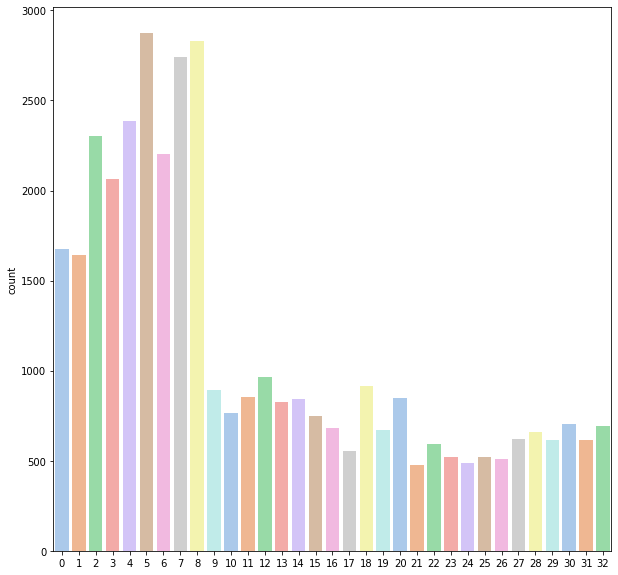

In [124]:
plt.figure(figsize=(10,10))
sns.countplot(labels.reshape((37303,)), palette="pastel") 

**Уникальные значения**

In [38]:
uniq = np.unique(letter_labels)
uniq

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32])

**Масштабирование**

In [45]:
images = images / 255.0

### Примеры изображений

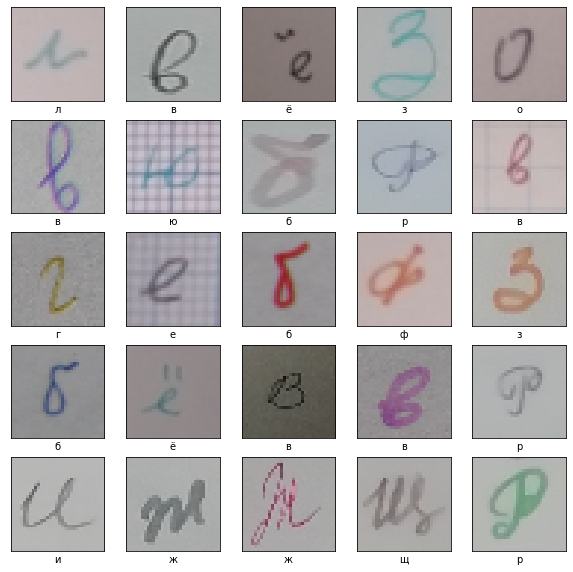

In [46]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    n = np.random.randint(images.shape[0])
    plt.imshow(images[n], cmap=plt.cm.binary)
    plt.xlabel(class_names[letter_labels[n][0]])
plt.show()


### Функции и классы

In [47]:
class CreateModel():
    def __init__(self, input_layer, output_layer, name='Model'):
        self.input_layer = input_layer
        self.output_layer = output_layer
        self.model = Model(inputs=input_layer, outputs=output, name=name)
    
    def compile_model(self, loss, optimizer='adam', metrics=['accuracy'], summary = True):
        self.model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
        if(summary):
            self.model.summary()
        

In [48]:
def plot_accuracy(history):
    fig, ax = plt.subplots(figsize=(10,7))

    ax.plot(history.history['accuracy'], color='hotpink', label='accuracy')
    ax.plot(history.history['val_accuracy'], color='slateblue', label='val_accuracy')

    ax.legend(loc = 'center right', fontsize=14)
    plt.xlabel('Шаг', fontsize=18)

    plt.title('Точность', fontsize=18)
    plt.tick_params(labelsize=14)
    plt.show()
    
def plot_loss(history):
    fig, ax = plt.subplots(figsize=(10,7))

    ax.plot(history.history['loss'], color='turquoise', label='loss')
    ax.plot(history.history['val_loss'], color='dodgerblue', label='val_loss')

    ax.legend(loc = 'center right', fontsize=14)
    plt.xlabel('Шаг', fontsize=18)

    plt.title('Потери', fontsize=18)
    plt.tick_params(labelsize=14)
    plt.show()

In [49]:
def plot_image(i, predictions_array, true_label, img):
    true_label, img = true_label[i][0], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                    100*np.max(predictions_array),
                                    class_names[true_label]),
                                    color=color)

def plot_value_array(i, predictions_array, true_label):
    true_label = true_label[i][0]
    plt.grid(False)
    plt.xticks(range(3))
    plt.yticks([])
    thisplot = plt.bar(range(3), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')


## Создание модели

**Создание слоев**

In [52]:
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, random_state=1)

In [53]:
shape = train_images.shape[1:]

**Tensorflow CNN example**

In [59]:
input_layer = Input(shape=shape)

x = Conv2D(filters=16, kernel_size=(3,3), activation='relu')(input_layer)
x = MaxPool2D(pool_size=(2,2))(x)

x = Conv2D(filters=32, kernel_size=(3,3), activation='relu')(x)
x = MaxPool2D(pool_size=(2,2))(x)

x = Conv2D(filters=32, kernel_size=(3,3), activation='relu')(x)

x = Flatten()(x)
x = Dense(32, activation='relu')(x)

output = Dense(len(uniq))(x)

**Компиляция**

In [60]:
modelTF = CreateModel(input_layer, output, name='Tensorflow_CNN_example')
modelTF.compile_model(loss = SparseCategoricalCrossentropy(from_logits = True))

Model: "Tensorflow_CNN_example"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 30, 30, 16)        448       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 15, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 13, 13, 32)        4640      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 4, 4, 32)          9248      
_________________________________________________________________
flatten_1 (Flatten)          (None, 512)    

### Обучение

In [61]:
history = modelTF.model.fit(train_images, train_labels, epochs=30, validation_split=0.2)

Epoch 1/30
700/700 [==============================] - 4s 5ms/step - loss: 3.1259 - accuracy: 0.1413 - val_loss: 2.6124 - val_accuracy: 0.2739
Epoch 2/30
700/700 [==============================] - 3s 5ms/step - loss: 2.1875 - accuracy: 0.3678 - val_loss: 1.9046 - val_accuracy: 0.4491
Epoch 3/30
700/700 [==============================] - 3s 5ms/step - loss: 1.7292 - accuracy: 0.4851 - val_loss: 1.6246 - val_accuracy: 0.5132
Epoch 4/30
700/700 [==============================] - 3s 5ms/step - loss: 1.4782 - accuracy: 0.5577 - val_loss: 1.4763 - val_accuracy: 0.5531
Epoch 5/30
700/700 [==============================] - 3s 5ms/step - loss: 1.2987 - accuracy: 0.6112 - val_loss: 1.2796 - val_accuracy: 0.6215
Epoch 6/30
700/700 [==============================] - 3s 5ms/step - loss: 1.1644 - accuracy: 0.6476 - val_loss: 1.2182 - val_accuracy: 0.6297
Epoch 7/30
700/700 [==============================] - 3s 5ms/step - loss: 1.0680 - accuracy: 0.6803 - val_loss: 1.1174 - val_accuracy: 0.6690
Epoch 

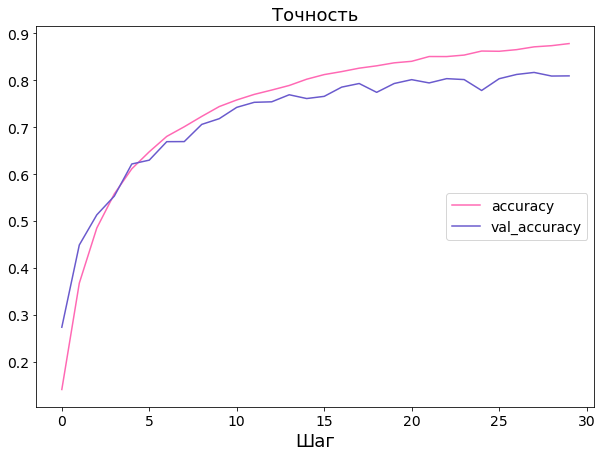

In [62]:
plot_accuracy(history)

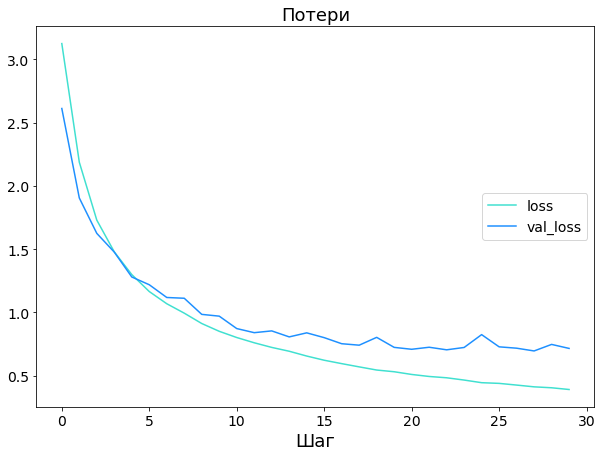

In [63]:
plot_loss(history)

### Тестирование

In [64]:
test_loss, test_acc = modelTF.model.evaluate(test_images,  test_labels, verbose=2)
print('\nTest accuracy:', test_acc)

292/292 - 1s - loss: 0.6799 - accuracy: 0.8150

Test accuracy: 0.8150332570075989


### Улучшенная модель

In [86]:
input_layer = Input(shape=shape)

x = Conv2D(filters=32, kernel_size=(3,3), activation='relu')(input_layer)
x = MaxPool2D(pool_size=(2,2))(x)

x = Conv2D(filters=64, kernel_size=(3,3), activation='relu')(x)
x = MaxPool2D(pool_size=(2,2))(x)

x = Conv2D(filters=128, kernel_size=(3,3), activation='relu')(x)
x = MaxPool2D(pool_size=(2,2))(x)

x = Flatten()(x)
x = Dense(128, activation='relu')(x)

output = Dense(len(uniq), activation='softmax')(x)

In [87]:
model = CreateModel(input_layer, output, name='Model')
model.compile_model(loss = SparseCategoricalCrossentropy())

Model: "Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 4, 4, 128)         73856     
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 2, 2, 128)         0     

In [88]:
history = model.model.fit(train_images, train_labels, epochs=20, validation_split=0.2)

Epoch 1/20
700/700 [==============================] - 4s 5ms/step - loss: 2.6706 - accuracy: 0.2558 - val_loss: 1.7060 - val_accuracy: 0.5180
Epoch 2/20
700/700 [==============================] - 4s 5ms/step - loss: 1.3207 - accuracy: 0.6203 - val_loss: 1.1133 - val_accuracy: 0.6837
Epoch 3/20
700/700 [==============================] - 4s 5ms/step - loss: 0.9084 - accuracy: 0.7377 - val_loss: 0.8229 - val_accuracy: 0.7652
Epoch 4/20
700/700 [==============================] - 3s 5ms/step - loss: 0.7050 - accuracy: 0.7919 - val_loss: 0.7176 - val_accuracy: 0.7909
Epoch 5/20
700/700 [==============================] - 3s 5ms/step - loss: 0.5784 - accuracy: 0.8293 - val_loss: 0.6116 - val_accuracy: 0.8284
Epoch 6/20
700/700 [==============================] - 3s 5ms/step - loss: 0.4871 - accuracy: 0.8525 - val_loss: 0.5952 - val_accuracy: 0.8251
Epoch 7/20
700/700 [==============================] - 4s 5ms/step - loss: 0.4205 - accuracy: 0.8747 - val_loss: 0.6320 - val_accuracy: 0.8215
Epoch 

**Улучшенная модель выглядит так:**

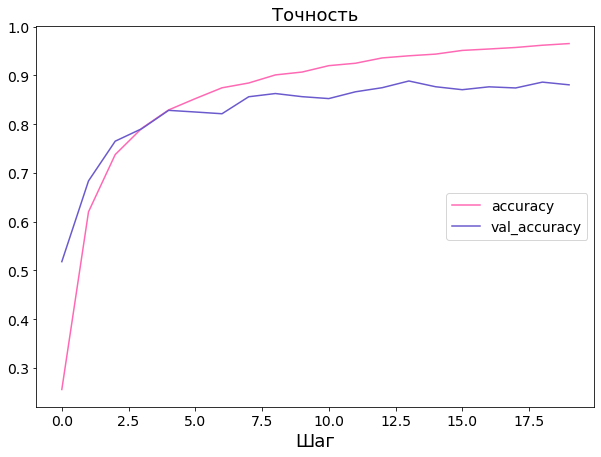

In [89]:
plot_accuracy(history)

Точность валидации достигнула максимума на 10-15 итерациях

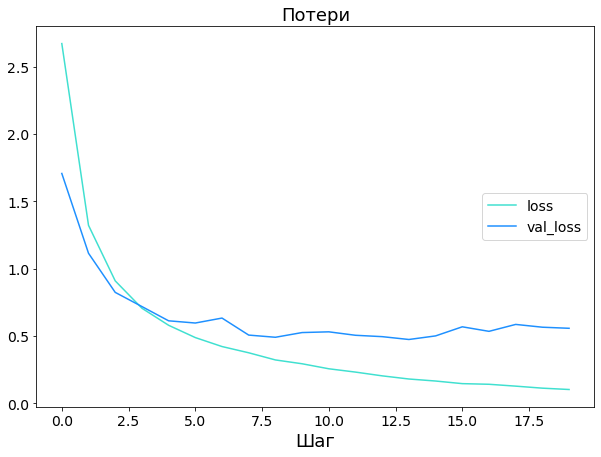

In [90]:
plot_loss(history)

Потери также начинают расти после 15 итераций. Это значит, что модель переобучается. 

Для достижения хорошего результата ей потребовалось меньше итераций чем у прежней.

In [72]:
test_loss, test_acc = model.model.evaluate(test_images,  test_labels, verbose=2)
print('\nTest accuracy:', test_acc)

292/292 - 1s - loss: 0.7482 - accuracy: 0.8655

Test accuracy: 0.8655372262001038


### Добавление регулизации

**lambda = 0.01**

In [73]:
l = 0.01

input_layer = Input(shape=shape)

x = Conv2D(filters=32, kernel_size=(3,3), activation='relu', 
           kernel_regularizer=tf.keras.regularizers.l2(l=l))(input_layer)
x = MaxPool2D(pool_size=(2,2))(x)

x = Conv2D(filters=64, kernel_size=(3,3), activation='relu', 
           kernel_regularizer=tf.keras.regularizers.l2(l=l))(x)
x = MaxPool2D(pool_size=(2,2))(x)

x = Conv2D(filters=128, kernel_size=(3,3), activation='relu', 
           kernel_regularizer=tf.keras.regularizers.l2(l=l))(x)
x = MaxPool2D(pool_size=(2,2))(x)

x = Flatten()(x)
x = Dense(128, activation='relu')(x)

output = Dense(len(uniq), activation='softmax')(x)

In [75]:
modelR = CreateModel(input_layer, output, name='Model_Regulization_0.01')
modelR.compile_model(loss = SparseCategoricalCrossentropy(), summary=False)

In [76]:
history = modelR.model.fit(train_images, train_labels, epochs=10, validation_split=0.2)

Epoch 1/10
700/700 [==============================] - 4s 6ms/step - loss: 3.3716 - accuracy: 0.0771 - val_loss: 3.2983 - val_accuracy: 0.0717
Epoch 2/10
700/700 [==============================] - 4s 6ms/step - loss: 3.2815 - accuracy: 0.0895 - val_loss: 3.2707 - val_accuracy: 0.0911
Epoch 3/10
700/700 [==============================] - 4s 6ms/step - loss: 3.1726 - accuracy: 0.1387 - val_loss: 2.9614 - val_accuracy: 0.1955
Epoch 4/10
700/700 [==============================] - 4s 6ms/step - loss: 2.6496 - accuracy: 0.2902 - val_loss: 2.3789 - val_accuracy: 0.3738
Epoch 5/10
700/700 [==============================] - 4s 6ms/step - loss: 2.2260 - accuracy: 0.4284 - val_loss: 2.0910 - val_accuracy: 0.4543
Epoch 6/10
700/700 [==============================] - 4s 6ms/step - loss: 1.9713 - accuracy: 0.5082 - val_loss: 1.8728 - val_accuracy: 0.5273
Epoch 7/10
700/700 [==============================] - 4s 6ms/step - loss: 1.7826 - accuracy: 0.5618 - val_loss: 1.7232 - val_accuracy: 0.5759
Epoch 

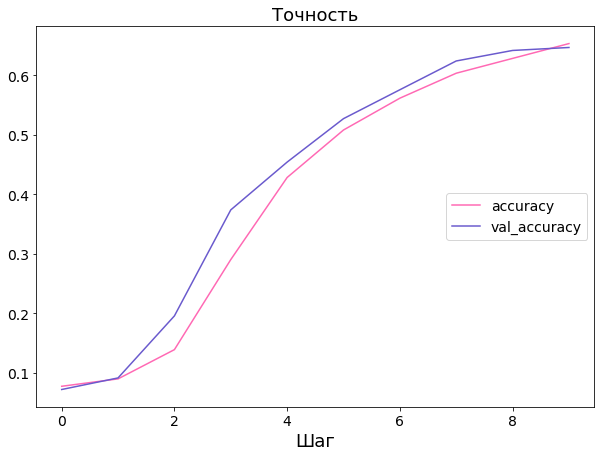

In [77]:
plot_accuracy(history)

In [78]:
test_loss, test_acc = modelR.model.evaluate(test_images,  test_labels, verbose=2)
print('\nTest accuracy:', test_acc)

292/292 - 1s - loss: 1.4991 - accuracy: 0.6377

Test accuracy: 0.6376795768737793


### Добавление слоев Dropout

In [95]:
input_layer = Input(shape=shape)

x = Conv2D(filters=32, kernel_size=(3,3), activation='relu')(input_layer)
x = MaxPool2D(pool_size=(2,2))(x)
x = Dropout(0.4)(x)

x = Conv2D(filters=64, kernel_size=(3,3), activation='relu')(x)
x = MaxPool2D(pool_size=(2,2))(x)
x = Dropout(0.4)(x)

x = Conv2D(filters=128, kernel_size=(3,3), activation='relu')(x)
x = MaxPool2D(pool_size=(2,2))(x)
x = Dropout(0.4)(x)

x = Flatten()(x)
x = Dense(128, activation='relu')(x)

output = Dense(len(uniq), activation='softmax')(x)

In [96]:
modelD = CreateModel(input_layer, output, name='Model')
modelD.compile_model(loss = SparseCategoricalCrossentropy(), summary=False)

In [97]:
history = modelD.model.fit(train_images, train_labels, epochs=20, validation_split=0.2)

Epoch 1/20
700/700 [==============================] - 5s 6ms/step - loss: 3.1017 - accuracy: 0.1403 - val_loss: 2.4798 - val_accuracy: 0.3150
Epoch 2/20
700/700 [==============================] - 4s 6ms/step - loss: 2.1395 - accuracy: 0.3926 - val_loss: 1.5417 - val_accuracy: 0.5863
Epoch 3/20
700/700 [==============================] - 4s 6ms/step - loss: 1.6468 - accuracy: 0.5222 - val_loss: 1.2106 - val_accuracy: 0.6737
Epoch 4/20
700/700 [==============================] - 4s 6ms/step - loss: 1.4033 - accuracy: 0.5951 - val_loss: 0.9727 - val_accuracy: 0.7425
Epoch 5/20
700/700 [==============================] - 4s 6ms/step - loss: 1.2469 - accuracy: 0.6342 - val_loss: 0.8563 - val_accuracy: 0.7645
Epoch 6/20
700/700 [==============================] - 5s 7ms/step - loss: 1.1327 - accuracy: 0.6656 - val_loss: 0.9367 - val_accuracy: 0.7361
Epoch 7/20
700/700 [==============================] - 4s 6ms/step - loss: 1.0503 - accuracy: 0.6884 - val_loss: 0.6985 - val_accuracy: 0.8090
Epoch 

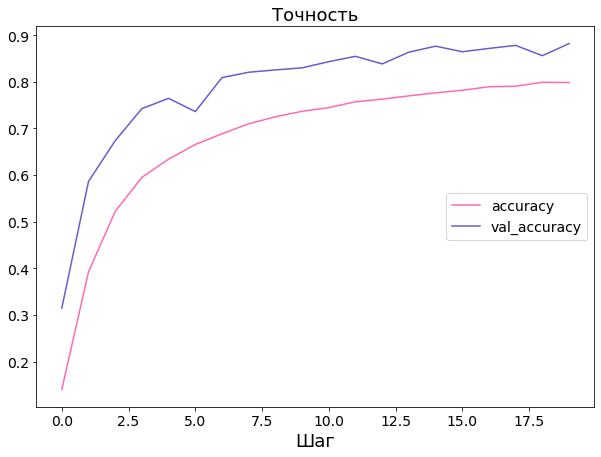

In [98]:
plot_accuracy(history)

In [99]:
test_loss, test_acc = modelD.model.evaluate(test_images,  test_labels, verbose=2)
print('\nTest accuracy:', test_acc)

292/292 - 1s - loss: 0.4080 - accuracy: 0.8832

Test accuracy: 0.883229672908783


**Использование слоев Dropout предотвратило переобучение и повысило точность валидации**

## Batch Normalization

In [100]:
input_layer = Input(shape=shape)

x = Conv2D(filters=32, kernel_size=(3,3), activation='relu')(input_layer)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2,2))(x)

x = Conv2D(filters=64, kernel_size=(3,3), activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2,2))(x)

x = Conv2D(filters=128, kernel_size=(3,3), activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2,2))(x)

x = Flatten()(x)
x = Dense(128, activation='relu')(x)

output = Dense(len(uniq), activation='softmax')(x)

In [101]:
modelB = CreateModel(input_layer, output, name='Model')
modelB.compile_model(loss = SparseCategoricalCrossentropy(), summary = False)

In [102]:
history = modelB.model.fit(train_images, train_labels, epochs=10, validation_split=0.2)

Epoch 1/10
700/700 [==============================] - 5s 6ms/step - loss: 1.5973 - accuracy: 0.5584 - val_loss: 1.4035 - val_accuracy: 0.6010
Epoch 2/10
700/700 [==============================] - 4s 6ms/step - loss: 0.5998 - accuracy: 0.8202 - val_loss: 1.1157 - val_accuracy: 0.6762
Epoch 3/10
700/700 [==============================] - 4s 6ms/step - loss: 0.3666 - accuracy: 0.8880 - val_loss: 0.9146 - val_accuracy: 0.7280
Epoch 4/10
700/700 [==============================] - 4s 6ms/step - loss: 0.2709 - accuracy: 0.9123 - val_loss: 0.6747 - val_accuracy: 0.8090
Epoch 5/10
700/700 [==============================] - 4s 6ms/step - loss: 0.1903 - accuracy: 0.9375 - val_loss: 0.7828 - val_accuracy: 0.7857
Epoch 6/10
700/700 [==============================] - 4s 6ms/step - loss: 0.1481 - accuracy: 0.9508 - val_loss: 0.6326 - val_accuracy: 0.8184
Epoch 7/10
700/700 [==============================] - 4s 6ms/step - loss: 0.1149 - accuracy: 0.9632 - val_loss: 0.5936 - val_accuracy: 0.8442
Epoch 

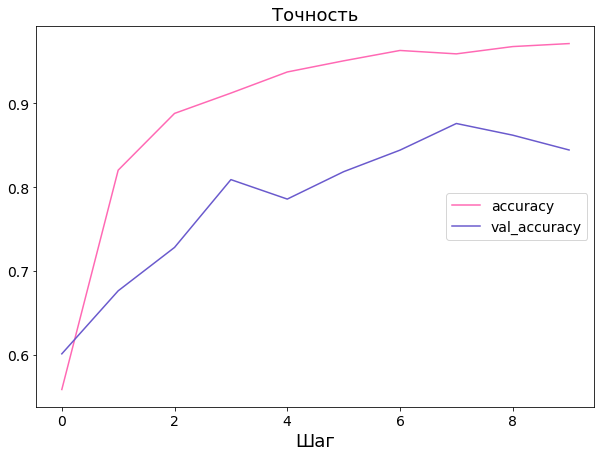

In [103]:
plot_accuracy(history)

In [104]:
test_loss, test_acc = modelB.model.evaluate(test_images,  test_labels, verbose=2)
print('\nTest accuracy:', test_acc)

292/292 - 1s - loss: 0.6857 - accuracy: 0.8366

Test accuracy: 0.8365858793258667


**Использование Batch Normalization ускорило обучение.**

### Dropout + Batch Normalization 

In [114]:
input_layer = Input(shape=shape)

x = Conv2D(filters=32, kernel_size=(3,3), activation='relu')(input_layer)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2,2))(x)
x = Dropout(0.4)(x)

x = Conv2D(filters=64, kernel_size=(3,3), activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2,2))(x)
x = Dropout(0.4)(x)

x = Conv2D(filters=128, kernel_size=(3,3), activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2,2))(x)
x = Dropout(0.4)(x)

x = Flatten()(x)
x = Dense(128, activation='relu')(x)

output = Dense(len(uniq), activation='softmax')(x)

In [115]:
modelDB = CreateModel(input_layer, output, name='Model')
modelDB.compile_model(loss = SparseCategoricalCrossentropy(), summary = False)

In [116]:
history = modelDB.model.fit(train_images, train_labels, epochs=20, validation_split=0.2)

Epoch 1/20
700/700 [==============================] - 5s 7ms/step - loss: 2.7486 - accuracy: 0.2502 - val_loss: 2.4608 - val_accuracy: 0.3150
Epoch 2/20
700/700 [==============================] - 4s 6ms/step - loss: 1.6197 - accuracy: 0.5269 - val_loss: 1.1521 - val_accuracy: 0.6669
Epoch 3/20
700/700 [==============================] - 4s 6ms/step - loss: 1.1613 - accuracy: 0.6511 - val_loss: 2.0560 - val_accuracy: 0.4775
Epoch 4/20
700/700 [==============================] - 4s 6ms/step - loss: 0.9554 - accuracy: 0.7097 - val_loss: 0.8206 - val_accuracy: 0.7525
Epoch 5/20
700/700 [==============================] - 5s 7ms/step - loss: 0.8334 - accuracy: 0.7472 - val_loss: 1.0767 - val_accuracy: 0.6869
Epoch 6/20
700/700 [==============================] - 4s 6ms/step - loss: 0.7454 - accuracy: 0.7689 - val_loss: 0.8841 - val_accuracy: 0.7398
Epoch 7/20
700/700 [==============================] - 4s 6ms/step - loss: 0.6893 - accuracy: 0.7881 - val_loss: 2.2822 - val_accuracy: 0.4961
Epoch 

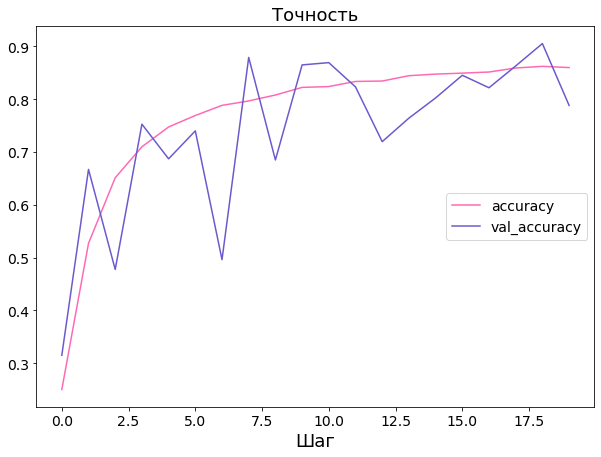

In [117]:
plot_accuracy(history)

In [118]:
test_loss, test_acc = modelB.model.evaluate(test_images,  test_labels, verbose=2)
print('\nTest accuracy:', test_acc)

292/292 - 1s - loss: 0.5982 - accuracy: 0.8792

Test accuracy: 0.8791550397872925


**Совмещение Dropout и Batch Normalization не дало значительного улучшения модели.**

## Вывод
Лучшей моделью оказалась модель с использованием Dropout. Она показала результат на тестовой выборке 0.88 и не страдает переобучением.